# Packages

In [1]:
#basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
import tarfile
import urllib
from datetime import datetime
from windrose import WindroseAxes
from matplotlib.cm import ScalarMappable
from pywaffle import Waffle

#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#data-preparation packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from astropy.table import QTable
# import astropy.units as u

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from yellowbrick.regressor import PredictionError, ResidualsPlot

from scipy import stats

#linear models packages
from sklearn.linear_model import LinearRegression


# Script

## Errors computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
def non_SC_error (data, power_curve):
    
    data['WS_pred']=data['WS1']
    
    data1=powercurve_computation(data, power_curve)
    
    errors_computation(data1, power_curve)
    
    
    return print('Not pursuing a SC error has been computed')

In [5]:
#errors computation

def errors_computation(data1, power_curve):
    
    data=data1.dropna()
    
    df=pd.DataFrame()
    df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    AEP_table=AEP_computation(data, power_curve)
    
    return AEP_table

In [6]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('Error plot performed')

In [7]:
def AEP_computation(data, power_curve1):
    
    #binning the WS_Pred unit and 0.5-centered
    data['WS_pred_bin']=pd.cut(data['WS_pred'],
                                       bins=list(np.arange(-0.25,28.0,0.5)),
                                                 labels=list(np.arange(0.0,28.0,0.5)))
#     #binning the WS_Pred at the beginning
#     data['WS_pred_bin']=pd.cut(data['WS_pred'],
#                                        bins=list(np.arange(0.0,28.5,0.5)),
#                                                  labels=list(np.arange(0.0,28.0,0.5)))

    
#     #binning the WS_Pred all at the end
#     data['WS_pred_bin']=pd.cut(data['WS_pred'],
#                                        bins=list(np.arange(-0.5,28.0,0.5)),
#                                                  labels=list(np.arange(0.0,28.0,0.5)))
    

        
    #creating the AEP (Annual Energy Production table)
    power_curve=power_curve1.copy()
    power_curve.set_index('Wind Speed [m/s]', inplace=True)
        
    AEP_table=pd.DataFrame()
    
    AEP_table['WS']=power_curve.index
    AEP_table.set_index('WS', inplace=True)
    AEP_table['WPC']=power_curve['Warranted Power Curve [kW]']   
    AEP_table['MPC_SC']=data.groupby('WS_pred_bin', as_index=True)['P'].mean()
#     WS1=AEP_table.index
#     AEP_table.reset_index()
#     AEP_table.insert(0, 'WS',WS1)

    #puedo rellenar los NaN de MPC_SC copiando lo que tendría que ser: WPC
    
#     for i in AEP_table.index:
#         if math.isnan(AEP_table.at[i, 'MPC_SC']):
#             AEP_table.at[i, 'MPC_SC']=AEP_table.at[i, 'WPC']
    
    AEP_table['WSAD']=power_curve['Wind Speed Distribution [Hr/Year]']
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
    AEP_table=AEP_table.dropna()
    
    AEP_table['WAEP']=AEP_table['WPC']*AEP_table['WSAD']
    AEP_table['MAEP_SC']=AEP_table['MPC_SC']*AEP_table['WSAD']
    
    
    
    #computing the metrics for later printing
    AEP_table2=pd.DataFrame(columns=AEP_table.columns)
    
    for i in AEP_table.index:
        if i>=3 and i<=15.5:
            AEP_table2.loc[i]=AEP_table.loc[i]
#             AEP_table2=pd.concat([AEP_table.loc[i], AEP_table2], ignore_index=True)
            
    
#     AEP_table2 = AEP_table[AEP_table.index.between(3.0,15.5)]
    
#     AEP_table2=AEP_table.dropna()
    
    #o igual aquí tendría que cortar la tabla para NaN values
    
    MAEP_SC=AEP_table2['MAEP_SC'].sum()
    WAEP=AEP_table2['WAEP'].sum()
    AEP_perc=(MAEP_SC/WAEP)*100
    AEP_diff=(MAEP_SC-WAEP)/1000
    
    
    
    #building table to print
    
    WS= AEP_table2.index
    WPC=AEP_table2['WPC']
    MPC=round(AEP_table2['MPC_SC'],0)
    WSAD=AEP_table2['WSAD']
    WAEP=round(AEP_table2['WAEP']/1000, 3)
    MAEP=round(AEP_table2['MAEP_SC']/1000, 3)
    
    AEP_table1=pd.DataFrame()
    AEP_table1['WS']=WS
    AEP_table1.set_index('WS', inplace=True)
    AEP_table1['WPC (kW)']=WPC
    AEP_table1['MPC_SC (kW)']=MPC
    AEP_table1['WSAD (h/year)']=WSAD
    AEP_table1['WAEP (MWh)']=WAEP
    AEP_table1['MAEP_SC (MWh)']=MAEP
    
    
    
    #printing the results

    print('')
    print('The computed AEP_table is: ')
    print(AEP_table1)
#     AEP_table_draw(AEP_table)
    print('')
    print('The AEP% of the Site Calibration is: ', round(AEP_perc, 3), '%')
    print('')
    print('The AEP difference of the Site Calibration is: ', round(AEP_diff, 3), 'MWh')
    print('')
    AEP_plot(data, AEP_table)                                
    
    
    return AEP_table2

In [8]:
def AEP_plot(data, AEP_table):
    
    #data is expected to contain: Target, WS_pred, P, P_pred
    #AEP_table is expected to contain: WS, WPC, MPC-SC

    #plotting the Power curves
    plt.figure(figsize=(10,6))
    plt.plot(data['WS_pred'], data['P'], marker='o', ls='', label='measured scatter', markersize=5, alpha=.1)
    plt.plot(AEP_table.index, AEP_table['WPC'], marker='o', color='black', linewidth=0.5, label='WPC', markersize=5)
    plt.plot(AEP_table.index, AEP_table['MPC_SC'], marker='o', color='red', linewidth=0.5, label='SC-MPC', markersize=5)


    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='Power interpolated with WPC and Target WS (kW)', xlabel='Predicted Wind Speed (m/s)');
    ax.set_title('Site Calibration Power Curve')
    ax.set_xlim(xmin=0, xmax=20)
#     ax.set_xlim(xmin=0, xmax=27.5)
    
    return print('Error plot performed')

In [9]:
def AEP_table_draw(AEP_table):
    
    #AEP_table is expected to contain: WPC, MPC_SC, WPC, WSAD, WAEP, MAEP_SC
    
    WS= AEP_table.index
    WPC=AEP_table['WPC']
    MPC=round(AEP_table['MPC_SC'],0)
    WSAD=AEP_table['WSAD']
    WAEP=round(AEP_table['WAEP']/1000000, 3)
    MAEP=round(AEP_table['MAEP_SC']/1000000, 3)
    
    row_headers=list(AEP_table.index)

    column_headers=('Wind speed bin (m/s)', 'WPC (kW)', 'MPC_SC (kW)',
                    'Annual Wind Distribution (h/year)', 'WAEP (GWh)', 'MAEP (GWh)')

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

    l_2d=[list(WS), list(WPC), list(MPC), list(WSAD), list(WAEP), list(MAEP)]

    cell_text=np.array(l_2d).T

    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()

    the_table=ax.table(cellText=cell_text,
                       rowLabels=row_headers,
                       rowColours=rcolors,
                       rowLoc='right',
                       colColours=ccolors,
                       colLabels=column_headers,
                       cellLoc ='center',
                       loc='upper center',
                       colWidths = [0.1] * 5)

    ax.set_title('Annual Energy Production for Site Calibration PC', 
                 fontweight ="bold", fontsize=14) 

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    return ('AEP table printed')



# row_headers=index
#     column_headers=('Overall', 'Stratified', 'Random', 'Rand. %error', 'Strat. %error')
    
#     rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
#     ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
    
#     l_2d=[list(Overall), list(Stratified), list(Random), list(Rand_error), list(Strat_error)]
     
#     cell_text=np.array(l_2d).T
    
#     fig, ax = plt.subplots(figsize=(12,5)) 
#     ax.set_axis_off()
    
#     the_table=ax.table(cellText=cell_text,
#                       rowLabels=row_headers,
#                       rowColours=rcolors,
#                       rowLoc='right',
#                       colColours=ccolors,
#                       colLabels=column_headers,
#                       cellLoc ='center',
#                       loc='upper center',
#                       colWidths = [0.1] * 5)

## Data reference

In [10]:
def WDbins_uncomplete(data):
    
    data1=data.copy()
    bins_2drop=[]
    
    #above and below 8 m/s para 36 heartbeats
    
    #classification
    for i in data.index:
        if data.at[i, 'WS1']>=8:
            data.at[i, '8 m/s']='Above'
        else:
            data.at[i, '8 m/s']='Below'
    
    columns=data[['WD_bin', '8 m/s']]
    df=columns.copy()
    
    binsx=df.groupby(['WD_bin']).count()
    bins2=pd.DataFrame(binsx)
    
    #filing the list bins_2drop
    for b in bins2.index:
        if bins2.at[b, '8 m/s']<36:
            bins_2drop.append(b)
            
    ########        
            
        
            
    #total para 144 heartbeats
    bins=data['WD_bin'].value_counts()
    bins1=pd.DataFrame(bins)
    
    
    for b in bins1.index:
        if bins1.at[b, 'WD_bin']<144:
            bins_2drop.append(b)
            
    #removing duplicates
    bins_2drop=list(dict.fromkeys(bins_2drop))
            
    print('Bins to drop: ', bins_2drop)
    
    
    #####dropping the values
    
    for i in data.index:
        if data.at[i, 'WD_bin'] in bins_2drop:
            data1=data1.drop(index=i)
    
    if '8 m/s' in data1.keys():
        data1=data1.drop(columns=['8 m/s'])
    data2=data1.reset_index(drop=True)
            
    print('Data removed for IEC computation: ', round((len(data)-len(data1))/len(data)*100, 2), '%')
    
    return data2

In [11]:
def power_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot(data['Target'], data['P'], marker='o', ls='', label='Power curve', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='Target wind speed (m/s)', ylabel='Power computed (kW)');
    ax.set_title(title)
    
    return print('Error plot performed')

In [12]:
#predicted wind speed at the hub height regarding regular SC

def FCF_application(data,matrix):
    
    data1=data.copy()
    data2=data.copy()
    
    
    
#     matrix=FCF_computation(data) # in this case, the FCFs will be computed for the train set
                                    #but will be applied to the test set
    
    
    for i in data1.index:
        for b in matrix.index:
            if data1.at[i, 'WD_bin']== b:
                data2.at[i, 'WS_pred']=data1.at[i, 'WS1']*matrix.at[b, 'ratio']
                
            
    return data2

In [13]:
def FCF_computation(data):
    
    if 'WD_bin' not in data.keys():
        print('Wind direction bin clustering missing')
        
    FCF_table=data.groupby('WD_bin', as_index=False)['ratio'].mean()
    FCF_table.set_index('WD_bin', inplace=True)
    
    FCF_table=FCF_table.dropna()
    
    print('The computed FCF_table is: ')
    print(FCF_table)
    
    
    return FCF_table

In [14]:
#reference data

def apply_reference(data, power_curve):
    
    #this function creates a reference dataFrame by using the IEC metholodogy
    #this function requires the WD_bins clustering
    #this function uses the following functions:
    # FCF_computation
    # FCF_application
    # 
    data1=data.copy()

    if 'WD_bin' not in data.keys():
        print('Wind direction bin clustering missing')
    


    #applying the FCFs computed internally on FCF_application :
    if 'WS_pred' not in data1.keys():
        data1=FCF_application(data1)
    
    if 'P_pred' not in data1.keys():
        print('power_computation missing')

    print('IEC method errors:')
    AEP_table=errors_computation(data1, power_curve)
    
    error_plot(data1, 'IEC method regression with computed FCFs')
    
    print('')
    print('Data removed for IEC computation: ', round(len(data1)/len(data)*100, 2), '%')

    
    return AEP_table

In [15]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    if 'Wind Speed [m/s]' in power_curve.keys():
        x=power_curve['Wind Speed [m/s]']
    else:
        x=power_curve.index
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [16]:
def plot_FCF (data, FCF_table1, cluster):
    
    FCF_table=FCF_table1.copy()
    
    WD_0in10=pd.DataFrame()
    WD_0in10['WD_bin']=list(range(1,37,1))
    WD_0in10.set_index('WD_bin', inplace=True)
    WD_0in10['WD']=list(range(5,360,10))
    
    
    WD_0in5=pd.DataFrame()
    WD_0in5['WD_bin']=list(range(1,73,1))
    WD_0in5.set_index('WD_bin', inplace=True)
    WD_0in5['WD']=list(np.arange(2.5,360,5))
    
    
    WD_5in10=pd.DataFrame()
    WD_5in10['WD_bin']=list(range(1,37,1))
    WD_5in10.set_index('WD_bin', inplace=True)
    WD_5in10['WD']=list(range(0,360,10))
    
    
    if cluster=='WD_0in10':
        FCF_table['WD']=WD_0in10['WD']
        FCF_table.set_index('WD', inplace=True)
    elif cluster=='WD_0in5':
        FCF_table['WD']=WD_0in5['WD']
        FCF_table.set_index('WD', inplace=True)
    elif cluster=='WD_5in10':
        FCF_table['WD']=WD_5in10['WD']
        FCF_table.set_index('WD', inplace=True)
        
        
    
    #plotting the FCFs
    plt.figure(figsize=(9,5))
    plt.plot(data['WD1'], data['ratio'], marker='o', ls='', label='ratio scatter', markersize=5, alpha=.1)
    plt.plot(FCF_table.index, FCF_table, marker='o', color='red', linewidth=0.5, label='FCF', markersize=5)


    plt.legend(fontsize=12)

    ax=plt.gca()
    ax.set(ylabel='WS ratio (Target/WS1)', xlabel='Wind direction (°)');
    ax.set_title('Flow Correction Factors')
#     ax.set_ylim(ymin=0, ymax=20)
        
        
    
    print('FCF plot performed')
    
    return FCF_table
    

## Data preparation

### Data uploading

In [17]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [18]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

### Train_test_split 

In [19]:
# to randomly split the dataset use:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [20]:
def stratified_split (data):
    
    
    #Stratified train_test_split in function of the target
    
    s=data['WS1']
    
    data_train_strat, data_test_strat = train_test_split(data, test_size=0.3, stratify=s, random_state=42)
     

    return data_train_strat, data_test_strat

In [21]:
def test_split (data1):
    
    data=data1.copy()
    
    #binning (clustering) the data by wind speed bins
    
#     data['wind speed bins']= pd.cut(data['Target'], 
#                                     bins=[3, 6, 8, 10, 12, 14, 21],
#                                     labels=['3 to 6', '6 to 8', '8 to 10', 
#                                             '10 to 12', '12 to 14', '14 to 21'])
    
    data['wind speed bins']= pd.cut(data['Target'], 
                                    bins=[0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21],
                                    labels=['4 to 5', '5 to 6','6 to 7', '7 to 8','8 to 9', '9 to 10',
                                            '10 to 11', '11 to 12', '12 to 13', '13 to 14', '14 to 15','15 to 16'])
    
    #regular/random train_test_split
    
    train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
    
    
    plt.figure(figsize=(8,6))
    sns.histplot(data['Target'], bins=15)
    
    ax=plt.gca()
    ax.set(xlabel='Target wind speed (m/s)');
    ax.set_title('Target Stratification')
    ax.set_xticks(np.arange(3,17,1))
    plt.show()
    
    
    #Stratified train_test_split in function of wind speed
    
    split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    for train_index, test_index in split.split(data, data['wind speed bins']):
        strat_train_set=data.loc[train_index]
        strat_test_set=data.loc[test_index]
        
    index= ['4 to 5', '5 to 6','6 to 7', '7 to 8','8 o 9', '9 to 10', 
            '10 to 11', '11 to 12', '12 to 13', '13 to 14','14 to 15','15 to 16']
    Overall= round(data['wind speed bins'].value_counts()/len(data),5)
    Stratified= round(strat_test_set['wind speed bins'].value_counts()/len(strat_test_set),5)
    Random= round(test_set['wind speed bins'].value_counts()/len(test_set), 5)
    Rand_error= round((Random-Overall)/Random*100,5)
    Strat_error= round((Stratified-Overall)/Stratified*100,5)
    
    #plotting the table of the comparison Random vs. Stratified
    
#     t = pd.DataFrame()
#     t['wind speed bin']=index
#     t['Overall']= Overall
#     t['Stratified']=Stratified
#     t['Random']=Random
#     t['Rand. %error']=Rand_error
#     t['Strat. %error']=Strat_error
#     t.set_index('wind speed bin', inplace=True)
    
#     print(t)
    
    row_headers=index
    column_headers=('Overall', 'Stratified', 'Random', 'Rand. %error', 'Strat. %error')
    
    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
    
    l_2d=[list(Overall), list(Stratified), list(Random), list(Rand_error), list(Strat_error)]
     
    cell_text=np.array(l_2d).T
    
    fig, ax = plt.subplots(figsize=(12,5)) 
    ax.set_axis_off()
    
    the_table=ax.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='right',
                      colColours=ccolors,
                      colLabels=column_headers,
                      cellLoc ='center',
                      loc='upper center',
                      colWidths = [0.1] * 5)
    
    ax.set_title('Random vs. Stratified by wind speed bin train_test_split', 
                 fontweight ="bold", fontsize=14) 
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    
    train_set=train_set.drop(columns='wind speed bins')
    test_set=test_set.drop(columns='wind speed bins')
    strat_train_set=strat_train_set.drop(columns='wind speed bins')
    strat_test_set=strat_test_set.drop(columns='wind speed bins')
     

    return strat_train_set, strat_test_set


### Get x,y

In [22]:
## a function just to get X and y

def get_xy(data):
    
    y=data['Target']
    
    X=data.drop(columns=['Target'])
    
    return X,y

### Feature Scaling

In [23]:
#%%% Feature scaling

def data_scaling(X_train, X_test):

    # Instantiate a Scaler--> NORMALIZATION
    scaler_norm = MinMaxScaler()

    # Get scaling parameters with the train sample exclusively,
    #using the Scaler.fit() function
    scaler_norm.fit(X_train)

    # Scale data using Scaler.transform()
    scaledX_train = pd.DataFrame(scaler_norm.transform(X_train),
                                columns= X_train.columns)
    
    scaledX_test = pd.DataFrame(scaler_norm.transform(X_test),
                               columns= X_test.columns)

    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,7), sharey=True)
    fig.tight_layout(pad=2.0)
    sns.set_theme(style="whitegrid")

    sns.boxplot(ax=ax1, y="variable", x="value", data=pd.melt(scaledX_train), 
                hue=None, orient="h", palette="Set2")
    ax1.set_xlabel('Feature scaling')
    ax1.set_ylabel('features')
    ax1.set_title('train scaled X data')
    
    sns.boxplot(ax=ax2, y="variable", x="value", data=pd.melt(scaledX_test), 
                hue=None, orient="h", palette="Set2")
    ax2.set_xlabel('Feature scaling')
    ax2.set_ylabel('features')
    ax2.set_title('test scaled X data')

    
    return scaledX_train, scaledX_test

### Unappend

In [24]:
def unappend(data, final_row):
    
    #this function unappends a dataframe into two new dataframes taken into consideration one final row.
    
    index_f=final_row-1
    
    df1=data.iloc[:index_f]
    df2=data.iloc[index_f:]
    
    df1=df1.reset_index(drop=True)
    df2=df2.reset_index(drop=True)
    
    return df1, df2

In [25]:
def unappend_data (data, value):
    
    #this function unappends a dataframe into two a new dataframe considering the flag values in the column named 'data'.
    
    df1=data.loc[data['data']==value]
    df1=df1.drop(columns=['data'])
    
    
    return df1

# Data analysis

## Dataset1

### WTG14

In [107]:
#upload the dataset with file_folder, file_name
data_ref14= uploading_csv('\Dataset1-Normal_Site','\data_ref14.csv')

data_ref14.keys()

Index(['time', 'HB_ref', 'T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2',
       'Rain', 'WS1', 'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor',
       'WSVer', 'WDVer', 'HB_TM', 'Target', 'TI', 'WSH', 'WD_bin', 'ratio',
       'tod', 'Daily_Cycle', 'WVeer', 'z_score', 'PT1', 'PT2', 'PTG', 'N2',
       'incr_WS', 'Ri', 'Atmospheric_Stability'],
      dtype='object')

In [108]:
data14=data_ref14.drop(columns=['Daily_Cycle', 'time', 'HB_ref', 'HB_TM', 'z_score', 'incr_WS', 'ratio', 'PT1', 'PT2', 'PTG', 'N2', 'Ri', 'Atmospheric_Stability'])
data14.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [109]:
data_iec14=WDbins_uncomplete(data14)

Bins to drop:  [10, 12, 11]
Data removed for IEC computation:  3.63 %


In [110]:
data_iec14.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [111]:
data_iec14['data']=14

In [112]:
data_iec14

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer,data
0,15.408628,76.88425,14.74184,80.20340,940.595676,1.137693,950.67080,1.135519,0.0,6.274426,...,245.0883,-0.182167,-1.553100,6.331317,0.113913,0.122742,14,3.166667,-2.105800,14
1,14.956176,79.41166,14.28318,82.97960,940.563384,1.139468,950.64368,1.137250,0.0,6.747767,...,243.7333,-0.398000,-3.290600,6.969913,0.105875,0.087538,14,3.333333,-4.844300,14
2,14.402350,82.88683,13.77520,86.36370,940.501452,1.141410,950.63504,1.139407,0.0,7.511865,...,244.6550,-0.404167,-2.907900,7.727134,0.090381,0.072224,14,3.500000,-5.786500,14
3,14.010448,85.25389,13.40032,88.93896,940.716472,1.143163,950.88572,1.141246,0.0,7.255095,...,253.1500,-0.285167,-1.891500,8.184956,0.110679,0.176741,15,3.666667,-2.904800,14
4,13.931068,85.82122,13.46482,88.70080,940.901592,1.143131,951.05132,1.141757,0.0,7.609600,...,267.9600,0.009167,0.367653,8.132529,0.120907,0.194960,16,3.833333,-1.850500,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,15.426856,97.35059,15.11122,93.08524,934.103840,1.128394,944.10056,1.127600,0.2,6.768632,...,291.7283,-0.017500,-0.116800,7.242526,0.087697,0.178255,18,16.000000,-6.499802,14
4348,15.546332,96.89353,15.35158,92.82240,934.194268,1.127563,944.18024,1.127234,0.2,6.739633,...,291.6133,0.133500,1.248329,7.170354,0.120747,0.269026,18,16.166667,-3.907355,14
4349,13.960048,93.93621,13.50100,94.70614,936.932016,1.138165,947.11088,1.136913,0.2,8.802164,...,292.5117,-0.006333,0.046102,9.542429,0.083126,0.154870,18,20.500000,-3.885846,14
4350,12.812818,96.67797,12.33188,97.73060,937.693972,1.143753,947.91320,1.142391,0.0,9.149534,...,293.1333,-0.159333,-0.860500,9.953794,0.092542,0.230430,18,22.666667,-3.182183,14


### WTG15

In [113]:
#upload the dataset with file_folder, file_name
data_ref15= uploading_csv('\Dataset1-Normal_Site','\data_ref15.csv')

data_ref15.keys()

Index(['time', 'HB_ref', 'T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2',
       'Rain', 'WS1', 'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor',
       'WSVer', 'WDVer', 'HB_TM', 'Target', 'TI', 'WSH', 'WD_bin', 'ratio',
       'tod', 'Daily_Cycle', 'WVeer', 'z_score'],
      dtype='object')

In [114]:
data15=data_ref15.drop(columns=['Daily_Cycle', 'time', 'HB_ref', 'HB_TM', 'z_score', 'ratio'])
data15.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [115]:
data_iec15=WDbins_uncomplete(data15)

Bins to drop:  [12, 11]
Data removed for IEC computation:  2.61 %


In [116]:
data_iec15.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'Target', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [117]:
data_iec15['data']=15

In [118]:
data_iec15

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer,data
0,6.085650,94.17214,6.10014,93.71344,954.143988,1.189236,964.32500,1.189856,0.0,10.344242,...,276.3417,-0.092000,-0.243700,12.527953,0.124286,0.311263,17,0.166667,-4.0661,15
1,6.079056,94.45006,6.14910,94.07316,954.046745,1.188821,964.22672,1.189762,0.0,11.150688,...,273.7233,0.039500,0.355504,11.499793,0.072248,0.258602,17,0.333333,-5.2553,15
2,6.104886,94.22682,6.03032,94.83376,954.004951,1.189408,964.18448,1.189601,0.0,9.586128,...,275.2650,0.026667,0.400133,11.303112,0.131896,0.259437,17,0.500000,-4.7128,15
3,6.045890,94.24500,6.00370,93.57296,953.938461,1.189432,964.11728,1.189767,0.0,9.807302,...,275.4667,-0.040667,0.098209,11.442116,0.122361,0.306062,17,0.666667,-4.4702,15
4,6.035026,92.03397,6.07924,90.09910,953.813554,1.188985,963.99104,1.189657,0.0,9.457401,...,275.7983,0.075333,0.781192,11.479754,0.113366,0.281998,17,0.833333,-4.1625,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6261,16.131140,76.31394,16.40012,74.03404,947.007692,1.138891,957.14048,1.140422,0.0,8.023870,...,272.9900,0.241000,1.678736,8.453869,0.061037,0.288621,17,23.333333,-12.0751,15
6262,15.888492,77.62946,16.16054,75.60144,946.995368,1.139820,957.12764,1.141354,0.0,7.650033,...,273.1733,0.254167,1.812748,7.901770,0.068866,0.296987,17,23.500000,-13.5525,15
6263,15.593498,79.33218,16.01826,76.13532,947.051840,1.140448,957.11264,1.142489,0.0,7.204232,...,270.2833,0.136667,1.182529,7.760936,0.087243,0.257411,17,23.666667,-14.3575,15
6264,15.420388,80.53941,15.89312,76.94148,947.079296,1.140977,957.11552,1.143171,0.0,6.208373,...,272.7967,-0.068333,-0.613500,7.164465,0.105960,0.223889,17,23.833333,-15.8710,15


### Append

In [119]:
data_iec1=data_iec14.append(data_iec15)
data_iec1=data_iec1.reset_index(drop=True)

In [120]:
data_iec1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer,data
0,15.408628,76.88425,14.74184,80.20340,940.595676,1.137693,950.67080,1.135519,0.0,6.274426,...,245.0883,-0.182167,-1.553100,6.331317,0.113913,0.122742,14,3.166667,-2.1058,14
1,14.956176,79.41166,14.28318,82.97960,940.563384,1.139468,950.64368,1.137250,0.0,6.747767,...,243.7333,-0.398000,-3.290600,6.969913,0.105875,0.087538,14,3.333333,-4.8443,14
2,14.402350,82.88683,13.77520,86.36370,940.501452,1.141410,950.63504,1.139407,0.0,7.511865,...,244.6550,-0.404167,-2.907900,7.727134,0.090381,0.072224,14,3.500000,-5.7865,14
3,14.010448,85.25389,13.40032,88.93896,940.716472,1.143163,950.88572,1.141246,0.0,7.255095,...,253.1500,-0.285167,-1.891500,8.184956,0.110679,0.176741,15,3.666667,-2.9048,14
4,13.931068,85.82122,13.46482,88.70080,940.901592,1.143131,951.05132,1.141757,0.0,7.609600,...,267.9600,0.009167,0.367653,8.132529,0.120907,0.194960,16,3.833333,-1.8505,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10613,16.131140,76.31394,16.40012,74.03404,947.007692,1.138891,957.14048,1.140422,0.0,8.023870,...,272.9900,0.241000,1.678736,8.453869,0.061037,0.288621,17,23.333333,-12.0751,15
10614,15.888492,77.62946,16.16054,75.60144,946.995368,1.139820,957.12764,1.141354,0.0,7.650033,...,273.1733,0.254167,1.812748,7.901770,0.068866,0.296987,17,23.500000,-13.5525,15
10615,15.593498,79.33218,16.01826,76.13532,947.051840,1.140448,957.11264,1.142489,0.0,7.204232,...,270.2833,0.136667,1.182529,7.760936,0.087243,0.257411,17,23.666667,-14.3575,15
10616,15.420388,80.53941,15.89312,76.94148,947.079296,1.140977,957.11552,1.143171,0.0,6.208373,...,272.7967,-0.068333,-0.613500,7.164465,0.105960,0.223889,17,23.833333,-15.8710,15


### Data split

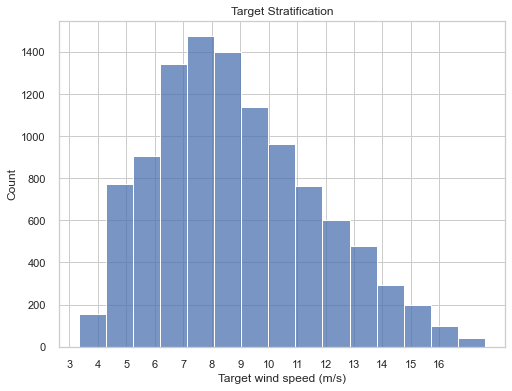

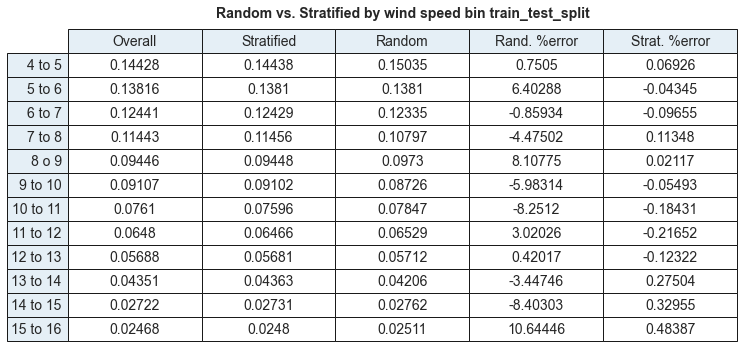

In [121]:
train_set1, test_set1 =test_split (data_iec1)

In [122]:
train_set1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer,data
4079,16.201308,60.10954,14.48760,65.75372,939.935744,1.137899,950.45264,1.132182,0.0,13.552994,...,277.1283,-0.109000,-0.094800,14.897693,0.140925,0.135358,17,16.333333,-4.187300,14
949,10.049890,72.00577,8.52174,78.61172,946.885856,1.170580,956.85908,1.164299,0.0,4.245499,...,285.9583,0.136833,2.259451,4.400995,0.215712,0.081990,18,8.000000,3.512000,14
8534,15.865868,61.53923,13.79808,70.06578,940.672012,1.141526,950.93312,1.134055,0.0,10.717854,...,280.7167,0.310333,1.944963,11.309387,0.147202,0.011736,18,11.166667,-11.362500,15
8218,28.056970,26.90862,26.40010,29.88426,946.194672,1.099944,955.84928,1.094257,0.0,7.556974,...,284.4350,0.898667,7.878478,8.495487,0.249192,0.082428,18,17.166667,-12.077845,15
6156,11.980224,88.97538,11.39014,92.16478,944.137552,1.155422,954.29636,1.153405,0.0,6.166716,...,263.0583,0.073167,0.879008,7.634325,0.115650,0.121034,16,22.000000,-2.051200,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9521,10.107108,79.03456,9.66230,80.21156,945.408276,1.164042,955.96604,1.162980,0.0,10.953449,...,299.7117,0.183667,1.183660,11.071395,0.175209,0.180845,20,6.166667,-3.529078,15
2994,19.046500,43.30341,18.74800,44.85964,948.066412,1.130998,958.25768,1.130483,0.0,9.516089,...,262.5217,-0.305667,-1.593600,10.204825,0.089698,0.217964,15,20.500000,-6.201400,14
1994,24.403894,32.50721,23.57904,34.44476,947.731532,1.112200,957.72920,1.109729,0.0,9.523224,...,281.1600,0.038167,0.296009,10.459681,0.085538,0.144478,17,18.833333,-11.093800,14
6151,13.123128,83.91466,12.54260,87.14728,944.381120,1.151060,954.49004,1.149084,0.0,5.502885,...,276.9817,-0.029667,-0.074100,6.481703,0.194076,0.200546,17,21.166667,-10.517500,15


In [123]:
test_set1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer,data
9103,11.917700,95.88934,11.22860,99.02576,947.715204,1.160459,958.07996,1.158229,0.0,9.327136,...,272.0750,-0.199500,-0.960700,8.923197,0.104137,0.256290,17,19.000000,-4.5116,15
4663,10.485892,90.73810,9.22412,97.77532,943.429158,1.163372,953.49584,1.158443,0.0,5.690536,...,260.5283,-0.272500,-2.347000,5.832447,0.164167,-0.047485,16,9.500000,3.9353,15
2234,23.225010,28.66008,20.97102,32.91376,949.156488,1.123745,959.01896,1.115598,0.0,7.878415,...,276.5567,0.099000,1.309779,8.476700,0.152816,0.058140,17,15.166667,-5.2413,14
6690,16.802244,46.21416,15.07772,51.58820,946.024216,1.142926,956.37116,1.136896,0.0,11.320769,...,275.6317,0.068667,0.648243,12.116230,0.118963,0.146372,17,17.166667,-9.3973,15
5494,9.451992,68.01819,9.36392,68.30136,949.795256,1.170678,960.07196,1.170653,0.0,6.292148,...,277.8283,0.071167,0.611564,7.069223,0.087145,0.233439,17,21.000000,-4.5842,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,15.470074,47.14745,13.54916,53.38320,946.648476,1.149775,956.89532,1.142713,0.0,9.771629,...,281.5583,0.122500,1.445047,10.032777,0.173309,0.134664,17,16.500000,-6.4703,14
4506,4.855596,98.62470,5.68840,95.88248,947.631834,1.182956,957.74336,1.186905,0.0,7.204536,...,263.7850,0.044500,0.284923,7.059427,0.043935,0.314968,16,3.666667,12.2288,15
6797,16.716648,46.32796,14.33996,53.04592,946.027804,1.145862,956.23400,1.137066,0.0,10.351225,...,277.5817,-0.221333,-1.030300,10.121035,0.115239,0.116309,18,11.666667,-4.4405,15
9451,14.093188,98.97038,13.96902,92.97540,947.187040,1.148748,957.04400,1.148310,0.0,5.470664,...,229.5100,-0.129667,-1.266800,5.376890,0.078761,0.219796,13,7.000000,-1.8746,15


### Get x,y

In [124]:
#save the flags of column 'data'


flags=pd.DataFrame(test_set1['data'].copy())
flags=flags.reset_index(drop=True)
flags


,data
0,15
1,15
2,14
3,15
4,15
...,...
3181,14
3182,15
3183,15
3184,15


In [125]:
flags['data'].value_counts()

15    1892
14    1294
Name: data, dtype: int64

In [126]:
train_set1=train_set1.drop(columns=['data'])
test_set1=test_set1.drop(columns=['data'])

In [127]:
train_set1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WSHor,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer
4079,16.201308,60.10954,14.48760,65.75372,939.935744,1.137899,950.45264,1.132182,0.0,13.552994,...,13.361270,277.1283,-0.109000,-0.094800,14.897693,0.140925,0.135358,17,16.333333,-4.187300
949,10.049890,72.00577,8.52174,78.61172,946.885856,1.170580,956.85908,1.164299,0.0,4.245499,...,4.202374,285.9583,0.136833,2.259451,4.400995,0.215712,0.081990,18,8.000000,3.512000
8534,15.865868,61.53923,13.79808,70.06578,940.672012,1.141526,950.93312,1.134055,0.0,10.717854,...,10.606570,280.7167,0.310333,1.944963,11.309387,0.147202,0.011736,18,11.166667,-11.362500
8218,28.056970,26.90862,26.40010,29.88426,946.194672,1.099944,955.84928,1.094257,0.0,7.556974,...,7.454491,284.4350,0.898667,7.878478,8.495487,0.249192,0.082428,18,17.166667,-12.077845
6156,11.980224,88.97538,11.39014,92.16478,944.137552,1.155422,954.29636,1.153405,0.0,6.166716,...,6.116306,263.0583,0.073167,0.879008,7.634325,0.115650,0.121034,16,22.000000,-2.051200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9521,10.107108,79.03456,9.66230,80.21156,945.408276,1.164042,955.96604,1.162980,0.0,10.953449,...,10.690130,299.7117,0.183667,1.183660,11.071395,0.175209,0.180845,20,6.166667,-3.529078
2994,19.046500,43.30341,18.74800,44.85964,948.066412,1.130998,958.25768,1.130483,0.0,9.516089,...,9.389801,262.5217,-0.305667,-1.593600,10.204825,0.089698,0.217964,15,20.500000,-6.201400
1994,24.403894,32.50721,23.57904,34.44476,947.731532,1.112200,957.72920,1.109729,0.0,9.523224,...,9.405141,281.1600,0.038167,0.296009,10.459681,0.085538,0.144478,17,18.833333,-11.093800
6151,13.123128,83.91466,12.54260,87.14728,944.381120,1.151060,954.49004,1.149084,0.0,5.502885,...,5.457168,276.9817,-0.029667,-0.074100,6.481703,0.194076,0.200546,17,21.166667,-10.517500


In [128]:
test_set1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WSHor,WDHor,WSVer,WDVer,Target,TI,WSH,WD_bin,tod,WVeer
9103,11.917700,95.88934,11.22860,99.02576,947.715204,1.160459,958.07996,1.158229,0.0,9.327136,...,9.236236,272.0750,-0.199500,-0.960700,8.923197,0.104137,0.256290,17,19.000000,-4.5116
4663,10.485892,90.73810,9.22412,97.77532,943.429158,1.163372,953.49584,1.158443,0.0,5.690536,...,5.668994,260.5283,-0.272500,-2.347000,5.832447,0.164167,-0.047485,16,9.500000,3.9353
2234,23.225010,28.66008,20.97102,32.91376,949.156488,1.123745,959.01896,1.115598,0.0,7.878415,...,7.789690,276.5567,0.099000,1.309779,8.476700,0.152816,0.058140,17,15.166667,-5.2413
6690,16.802244,46.21416,15.07772,51.58820,946.024216,1.142926,956.37116,1.136896,0.0,11.320769,...,11.135480,275.6317,0.068667,0.648243,12.116230,0.118963,0.146372,17,17.166667,-9.3973
5494,9.451992,68.01819,9.36392,68.30136,949.795256,1.170678,960.07196,1.170653,0.0,6.292148,...,6.247677,277.8283,0.071167,0.611564,7.069223,0.087145,0.233439,17,21.000000,-4.5842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,15.470074,47.14745,13.54916,53.38320,946.648476,1.149775,956.89532,1.142713,0.0,9.771629,...,9.638181,281.5583,0.122500,1.445047,10.032777,0.173309,0.134664,17,16.500000,-6.4703
4506,4.855596,98.62470,5.68840,95.88248,947.631834,1.182956,957.74336,1.186905,0.0,7.204536,...,7.139528,263.7850,0.044500,0.284923,7.059427,0.043935,0.314968,16,3.666667,12.2288
6797,16.716648,46.32796,14.33996,53.04592,946.027804,1.145862,956.23400,1.137066,0.0,10.351225,...,10.216370,277.5817,-0.221333,-1.030300,10.121035,0.115239,0.116309,18,11.666667,-4.4405
9451,14.093188,98.97038,13.96902,92.97540,947.187040,1.148748,957.04400,1.148310,0.0,5.470664,...,5.329551,229.5100,-0.129667,-1.266800,5.376890,0.078761,0.219796,13,7.000000,-1.8746


In [129]:
#data x,y



X_train1,y_train1=get_xy(train_set1)
X_test1,y_test1=get_xy(test_set1)

In [130]:
X_train1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WD4,WSHor,WDHor,WSVer,WDVer,TI,WSH,WD_bin,tod,WVeer
4079,16.201308,60.10954,14.48760,65.75372,939.935744,1.137899,950.45264,1.132182,0.0,13.552994,...,168.386400,13.361270,277.1283,-0.109000,-0.094800,0.140925,0.135358,17,16.333333,-4.187300
949,10.049890,72.00577,8.52174,78.61172,946.885856,1.170580,956.85908,1.164299,0.0,4.245499,...,169.761800,4.202374,285.9583,0.136833,2.259451,0.215712,0.081990,18,8.000000,3.512000
8534,15.865868,61.53923,13.79808,70.06578,940.672012,1.141526,950.93312,1.134055,0.0,10.717854,...,179.333300,10.606570,280.7167,0.310333,1.944963,0.147202,0.011736,18,11.166667,-11.362500
8218,28.056970,26.90862,26.40010,29.88426,946.194672,1.099944,955.84928,1.094257,0.0,7.556974,...,184.489845,7.454491,284.4350,0.898667,7.878478,0.249192,0.082428,18,17.166667,-12.077845
6156,11.980224,88.97538,11.39014,92.16478,944.137552,1.155422,954.29636,1.153405,0.0,6.166716,...,152.372400,6.116306,263.0583,0.073167,0.879008,0.115650,0.121034,16,22.000000,-2.051200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9521,10.107108,79.03456,9.66230,80.21156,945.408276,1.164042,955.96604,1.162980,0.0,10.953449,...,190.181158,10.690130,299.7117,0.183667,1.183660,0.175209,0.180845,20,6.166667,-3.529078
2994,19.046500,43.30341,18.74800,44.85964,948.066412,1.130998,958.25768,1.130483,0.0,9.516089,...,155.922700,9.389801,262.5217,-0.305667,-1.593600,0.089698,0.217964,15,20.500000,-6.201400
1994,24.403894,32.50721,23.57904,34.44476,947.731532,1.112200,957.72920,1.109729,0.0,9.523224,...,179.537100,9.405141,281.1600,0.038167,0.296009,0.085538,0.144478,17,18.833333,-11.093800
6151,13.123128,83.91466,12.54260,87.14728,944.381120,1.151060,954.49004,1.149084,0.0,5.502885,...,174.899600,5.457168,276.9817,-0.029667,-0.074100,0.194076,0.200546,17,21.166667,-10.517500


In [131]:
y_train1

4079    14.897693
949      4.400995
8534    11.309387
8218     8.495487
6156     7.634325
          ...    
9521    11.071395
2994    10.204825
1994    10.459681
6151     6.481703
3019     8.594870
Name: Target, Length: 7432, dtype: float64

### Feature Scaling

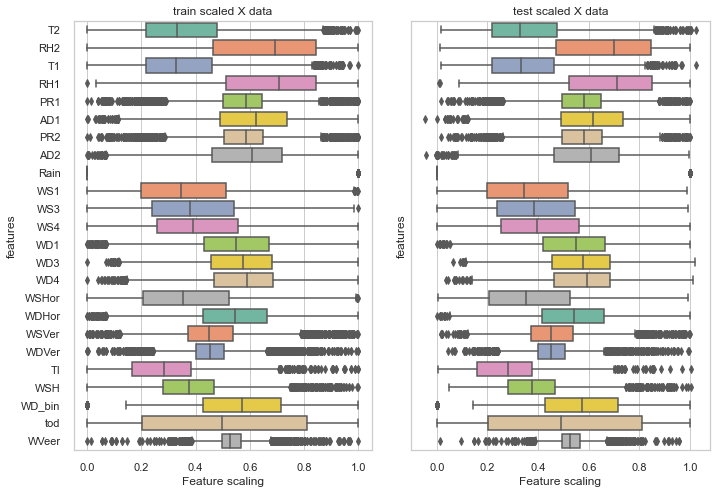

In [132]:
#feature scaling

X_train1, X_test1=data_scaling(X_train1, X_test1)

### Unappend

In [133]:
y_test1=pd.DataFrame(y_test1)
y_test1=y_test1.reset_index(drop=True)

In [134]:
y_test1

,Target
0,8.923197
1,5.832447
2,8.476700
3,12.116230
4,7.069223
...,...
3181,10.032777
3182,7.059427
3183,10.121035
3184,5.376890


In [135]:
X_test1['data']=flags.copy()
y_test1['data']=flags.copy()

In [136]:
X_test1

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WSHor,WDHor,WSVer,WDVer,TI,WSH,WD_bin,tod,WVeer,data
0,0.279127,0.958212,0.266160,0.991273,0.641810,0.712901,0.649882,0.686000,0.0,0.444426,...,0.454286,0.549879,0.345055,0.398560,0.265876,0.472741,0.571429,0.797203,0.540682,15
1,0.227512,0.897211,0.194242,0.977334,0.483673,0.738366,0.481987,0.687836,0.0,0.141014,...,0.151295,0.406759,0.303201,0.325167,0.439854,0.074045,0.428571,0.398601,0.644586,15
2,0.686743,0.162077,0.615702,0.254286,0.694987,0.391943,0.684273,0.320279,0.0,0.323555,...,0.331420,0.605429,0.516197,0.518763,0.406958,0.212675,0.571429,0.636364,0.531706,14
3,0.455209,0.369954,0.404260,0.462460,0.579419,0.559625,0.587297,0.502990,0.0,0.610761,...,0.615602,0.593964,0.498806,0.483740,0.308845,0.328477,0.571429,0.720280,0.480583,15
4,0.190241,0.628160,0.199258,0.648771,0.718555,0.802236,0.722840,0.792583,0.0,0.191208,...,0.200446,0.621191,0.500239,0.481799,0.216630,0.442751,0.571429,0.881119,0.539789,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3181,0.407186,0.381006,0.349418,0.482470,0.602452,0.619500,0.606494,0.552892,0.0,0.481511,...,0.488426,0.667424,0.529670,0.525925,0.466349,0.313111,0.571429,0.692308,0.516588,14
3182,0.024546,0.990605,0.067386,0.956234,0.638734,0.909572,0.637554,0.932005,0.0,0.267331,...,0.276198,0.447125,0.484950,0.464506,0.091399,0.549754,0.428571,0.153846,0.746604,15
3183,0.452124,0.371302,0.377790,0.478710,0.579552,0.585292,0.582273,0.504448,0.0,0.529869,...,0.537535,0.618134,0.332537,0.394876,0.298053,0.289021,0.714286,0.489510,0.541557,15
3184,0.357551,0.994698,0.364482,0.923827,0.622323,0.610522,0.611940,0.600908,0.0,0.122669,...,0.122463,0.022290,0.385093,0.382355,0.192332,0.424845,0.000000,0.293706,0.573119,15


In [137]:
X_test14=unappend_data (X_test1, 14)
X_test15=unappend_data (X_test1, 15)

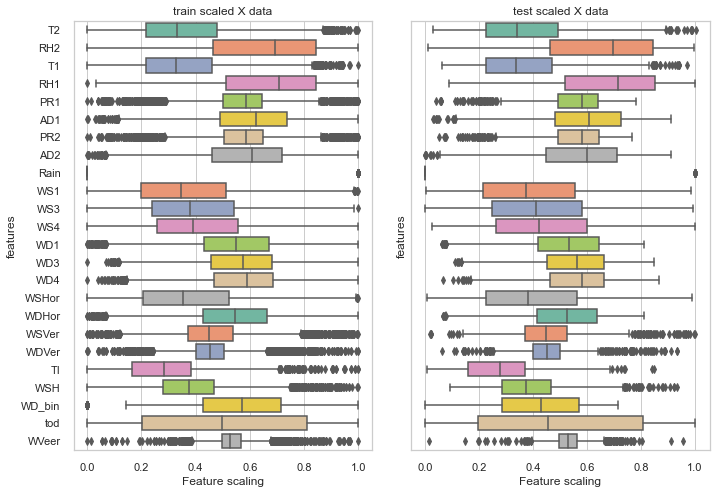

In [138]:
X_train1, X_test14=data_scaling(X_train1, X_test14)

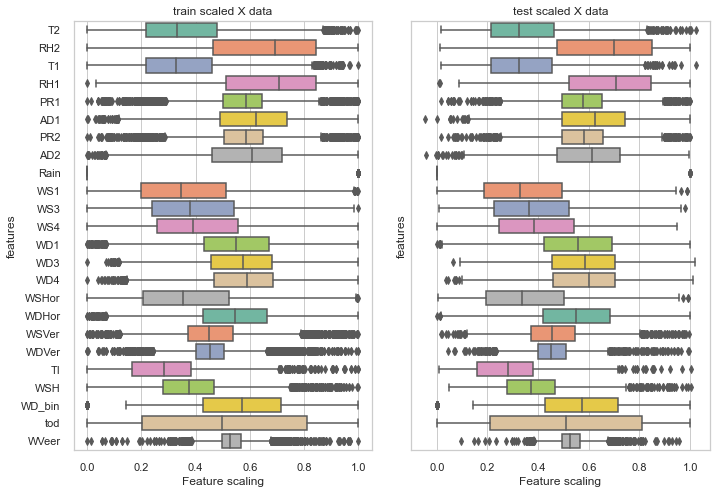

In [139]:
X_train1, X_test15=data_scaling(X_train1, X_test15)

In [140]:
y_test14=unappend_data (y_test1, 14)
y_test15=unappend_data (y_test1, 15)

In [141]:
y_test14

,Target
2,8.476700
5,10.447586
6,8.664361
7,9.912774
8,9.596844
...,...
3175,7.825251
3176,8.458561
3179,5.542412
3181,10.032777


In [142]:
y_train1

4079    14.897693
949      4.400995
8534    11.309387
8218     8.495487
6156     7.634325
          ...    
9521    11.071395
2994    10.204825
1994    10.459681
6151     6.481703
3019     8.594870
Name: Target, Length: 7432, dtype: float64

In [144]:
y_train1

4079    14.897693
949      4.400995
8534    11.309387
8218     8.495487
6156     7.634325
          ...    
9521    11.071395
2994    10.204825
1994    10.459681
6151     6.481703
3019     8.594870
Name: Target, Length: 7432, dtype: float64

In [145]:
y_train1=pd.DataFrame(y_train1)

In [146]:
y_train1

,Target
4079,14.897693
949,4.400995
8534,11.309387
8218,8.495487
6156,7.634325
...,...
9521,11.071395
2994,10.204825
1994,10.459681
6151,6.481703


In [147]:
y_train1=y_train1.reset_index(drop=True)

In [148]:
y_train1

,Target
0,14.897693
1,4.400995
2,11.309387
3,8.495487
4,7.634325
...,...
7427,11.071395
7428,10.204825
7429,10.459681
7430,6.481703


### Data saving

In [149]:
save(X_train1,'\General','\X_train1.csv')
save(X_test14,'\General','\X_test14.csv')
save(X_test15,'\General','\X_test15.csv')
save(y_train1,'\General','\y_train1.csv')
save(y_test14,'\General','\y_test14.csv')
save(y_test15,'\General','\y_test15.csv')

file \X_train1.csv saved in \General folder
file \X_test14.csv saved in \General folder
file \X_test15.csv saved in \General folder
file \y_train1.csv saved in \General folder
file \y_test14.csv saved in \General folder
file \y_test15.csv saved in \General folder


## Dataset2

### T11

In [168]:
#upload the dataset with file_folder, file_name
data_ref11= uploading_csv('\Dataset2-Complex_Site','\data_iec11.csv')

data_ref11.keys()

Index(['time', 'WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor',
       'T1', 'RH1', 'PR1', 'Rain', 'HB_ref', 'Target', 'HB_TM', 'WSH', 'WVeer',
       'TI', 'WDVer', 'WD_bin', 'ratio', 'AD1', 'tod', 'Daily_Cycle',
       'z_score'],
      dtype='object')

In [169]:
data11=data_ref11.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'ratio', 'T1', 'PR1', 'AD1'])
data11.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'Rain', 'Target', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [170]:
data_iec11=WDbins_uncomplete(data11)

Bins to drop:  [18, 30, 20, 19, 31]
Data removed for IEC computation:  4.37 %


In [171]:
data_iec11['data']=11

In [172]:
data_iec11

,WS1,WS3,WS4,WD1,WD4,WSHor,WSVer,WDHor,RH1,Rain,Target,WSH,WVeer,TI,WDVer,WD_bin,tod,data
0,9.009043,8.778610,8.626575,124.57827,121.43038,9.047999,0.494000,124.3233,81.50517,0.0,10.659164,0.030854,3.14789,0.129681,3.125115,25,17.666667,11
1,8.015360,8.120598,7.812058,124.73822,121.06967,8.110833,0.825000,124.4567,84.23542,0.0,11.149108,0.016600,3.66855,0.159026,5.807911,25,17.833333,11
2,8.929196,8.585892,8.086405,124.87563,121.67026,8.996333,0.581833,124.8133,84.36862,0.0,11.834874,0.086831,3.20537,0.188124,3.700422,25,18.000000,11
3,10.766187,10.083536,9.718052,132.77941,128.40677,10.893830,0.305000,132.2433,82.48145,0.0,10.945073,0.093585,4.37264,0.115491,1.603720,27,18.166667,11
4,11.091125,10.608327,10.216608,132.63436,133.06373,11.199330,0.403667,132.3050,85.36727,0.0,11.964325,0.073170,-0.42937,0.087165,2.064265,27,18.333333,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268,5.440251,5.594206,5.338407,103.95688,110.04661,5.511833,0.881667,103.9783,86.90575,0.0,5.800333,0.004342,-6.08973,0.148846,9.087979,21,9.166667,11
9269,5.558906,5.753691,5.412889,103.85553,103.35515,5.612333,1.109500,104.1867,85.89897,0.0,6.070974,0.011358,0.50038,0.127027,11.182593,21,9.333333,11
9270,5.734387,5.416799,4.821272,107.15631,96.55578,5.779500,1.370500,107.2150,81.19512,0.0,6.193441,0.153833,10.60053,0.166520,13.340217,22,10.166667,11
9271,5.834799,5.885465,5.671493,110.15740,109.92623,5.905833,0.486833,109.9517,80.83170,0.0,5.552256,0.013661,0.23117,0.114545,4.712387,23,10.500000,11


### T17

In [173]:
#upload the dataset with file_folder, file_name
data_ref17= uploading_csv('\Dataset2-Complex_Site','\data_iec17.csv')

data_ref17.keys()

Index(['time', 'WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor',
       'PR1', 'Rain', 'HB_ref', 'Target', 'HB_TM', 'WSH', 'WVeer', 'TI',
       'WDVer', 'WD_bin', 'ratio', 'tod', 'Daily_Cycle', 'z_score'],
      dtype='object')

In [174]:
data17=data_ref17.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'ratio'])
data17.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'PR1',
       'Rain', 'Target', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [175]:
data_iec17=WDbins_uncomplete(data17)

Bins to drop:  []
Data removed for IEC computation:  0.0 %


In [177]:
data_iec17['data']=17

In [178]:
data_iec17

,WS1,WS3,WS4,WD1,WD4,WSHor,WSVer,WDHor,PR1,Rain,Target,WSH,WVeer,TI,WDVer,WD_bin,tod,data
0,4.385820,4.420996,3.931383,115.78878,114.97507,4.466166,0.372333,116.1250,920.14028,0.0,4.542531,0.099567,0.81371,0.128295,4.765588,24,17.833333,17
1,5.088855,5.211028,4.634035,119.93931,114.54060,5.190500,0.184333,120.9900,920.25554,0.0,5.324889,0.085221,5.39871,0.096877,2.033924,24,18.000000,17
2,4.072067,3.627976,3.192201,107.11110,94.94241,4.133500,0.287000,106.7500,923.92364,0.0,5.501566,0.221589,12.16869,0.070437,3.971825,22,23.166667,17
3,4.640515,4.164212,3.538357,108.20426,103.97638,4.738833,0.277833,107.7700,923.81210,0.0,5.812650,0.246823,4.22788,0.075342,3.355356,22,23.333333,17
4,4.904404,4.424902,3.909940,109.27826,106.89428,5.002333,0.190667,108.6217,923.71190,0.0,5.983040,0.206271,2.38398,0.084041,2.182804,22,23.500000,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6241,4.117184,3.870592,3.178339,103.37257,108.32730,4.174666,-0.008833,102.6183,929.32994,0.0,4.866430,0.235580,-4.95473,0.022035,-0.121234,21,23.166667,17
6242,4.050925,3.787116,3.179258,100.09352,106.89917,4.096000,0.004333,98.9783,929.34368,0.0,4.848552,0.220549,-6.80565,0.030677,0.060616,21,23.333333,17
6243,4.527224,4.240489,3.529780,107.43656,113.58363,4.595833,0.157667,107.0600,929.21396,0.0,5.053155,0.226534,-6.14707,0.042390,1.964844,22,23.500000,17
6244,4.700952,4.686587,4.198659,113.52876,117.50105,4.799833,0.174833,113.5200,929.14082,0.0,5.110693,0.102857,-3.97229,0.052401,2.086069,23,23.666667,17


### T22

In [179]:
#upload the dataset with file_folder, file_name
data_ref22= uploading_csv('\Dataset2-Complex_Site','\data_iec22.csv')

data_ref22.keys()

Index(['time', 'WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor',
       'RH1', 'PR1', 'Rain', 'HB_ref', 'Target', 'HB_TM', 'WSH', 'WVeer', 'TI',
       'WDVer', 'ratio', 'WD_bin', 'tod', 'Daily_Cycle', 'z_score'],
      dtype='object')

In [180]:
data22=data_ref22.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'ratio', 'PR1'])
data22.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'Rain', 'Target', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [181]:
data_iec22=WDbins_uncomplete(data22)

Bins to drop:  [12, 16, 17, 18, 30, 31, 33, 19, 29]
Data removed for IEC computation:  3.24 %


In [182]:
data_iec22['data']=22

In [183]:
data_iec22

,WS1,WS3,WS4,WD1,WD4,WSHor,WSVer,WDHor,RH1,Rain,Target,WSH,WVeer,TI,WDVer,WD_bin,tod,data
0,8.263525,7.459259,6.605200,112.92920,104.19550,8.239266,-0.456500,112.8267,55.43035,0.0,7.008901,0.213364,8.73370,0.209577,-3.171254,23,9.333333,22
1,9.409018,9.394673,8.677561,109.87886,104.81298,9.489350,-0.341933,109.5500,34.28729,0.0,7.398603,0.077087,5.06588,0.136362,-2.063667,22,9.833333,22
2,8.427274,8.066410,7.469516,107.44650,100.51363,8.390683,-0.187333,107.3367,88.50758,0.0,6.622659,0.114918,6.93287,0.170031,-1.278993,22,10.000000,22
3,6.164058,5.710250,5.349654,120.67881,113.49175,6.117516,-0.058150,120.1400,82.22576,0.0,7.676016,0.134978,7.18706,0.177656,-0.544608,25,17.166667,22
4,6.378974,5.970708,5.512622,120.20757,122.71324,6.342583,0.006083,119.1867,83.04718,0.0,7.788232,0.139040,-2.50567,0.158880,0.054954,25,17.333333,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5732,4.496033,4.248656,3.799716,103.19543,98.84517,4.488516,0.259900,103.7783,87.92510,0.0,5.767007,0.160283,4.35026,0.216580,3.313916,21,7.333333,22
5733,4.909347,4.499466,4.077920,95.29759,95.42402,4.902067,0.095467,95.4517,88.20224,0.0,6.152089,0.176748,-0.12643,0.151816,1.115681,20,7.500000,22
5734,4.023212,3.574416,3.116387,97.96379,103.16133,4.000016,-0.111233,97.6850,88.21150,0.0,5.672581,0.243285,-5.19754,0.225263,-1.592883,20,7.666667,22
5735,4.152775,4.023271,3.794447,96.34918,99.23390,4.115483,-0.045267,96.2700,87.87852,0.0,5.471725,0.085956,-2.88472,0.177853,-0.630177,20,7.833333,22


### Append

In [184]:
data_iec2=data_iec11.append([data_iec17, data_iec22])
data_iec2=data_iec2.reset_index(drop=True)

In [188]:
data_iec2=data_iec2.drop(columns=['PR1'])

In [189]:
data_iec2

,WS1,WS3,WS4,WD1,WD4,WSHor,WSVer,WDHor,RH1,Rain,Target,WSH,WVeer,TI,WDVer,WD_bin,tod,data
0,9.009043,8.778610,8.626575,124.57827,121.43038,9.047999,0.494000,124.3233,81.50517,0.0,10.659164,0.030854,3.14789,0.129681,3.125115,25,17.666667,11
1,8.015360,8.120598,7.812058,124.73822,121.06967,8.110833,0.825000,124.4567,84.23542,0.0,11.149108,0.016600,3.66855,0.159026,5.807911,25,17.833333,11
2,8.929196,8.585892,8.086405,124.87563,121.67026,8.996333,0.581833,124.8133,84.36862,0.0,11.834874,0.086831,3.20537,0.188124,3.700422,25,18.000000,11
3,10.766187,10.083536,9.718052,132.77941,128.40677,10.893830,0.305000,132.2433,82.48145,0.0,10.945073,0.093585,4.37264,0.115491,1.603720,27,18.166667,11
4,11.091125,10.608327,10.216608,132.63436,133.06373,11.199330,0.403667,132.3050,85.36727,0.0,11.964325,0.073170,-0.42937,0.087165,2.064265,27,18.333333,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21251,4.496033,4.248656,3.799716,103.19543,98.84517,4.488516,0.259900,103.7783,87.92510,0.0,5.767007,0.160283,4.35026,0.216580,3.313916,21,7.333333,22
21252,4.909347,4.499466,4.077920,95.29759,95.42402,4.902067,0.095467,95.4517,88.20224,0.0,6.152089,0.176748,-0.12643,0.151816,1.115681,20,7.500000,22
21253,4.023212,3.574416,3.116387,97.96379,103.16133,4.000016,-0.111233,97.6850,88.21150,0.0,5.672581,0.243285,-5.19754,0.225263,-1.592883,20,7.666667,22
21254,4.152775,4.023271,3.794447,96.34918,99.23390,4.115483,-0.045267,96.2700,87.87852,0.0,5.471725,0.085956,-2.88472,0.177853,-0.630177,20,7.833333,22


### Data split

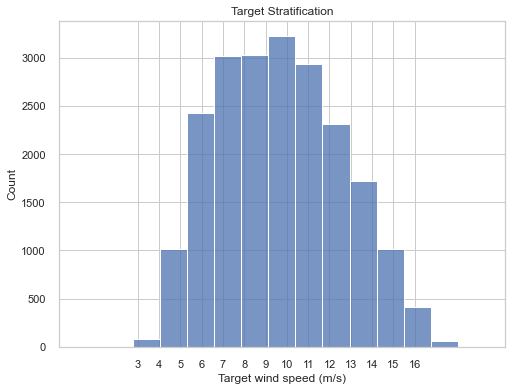

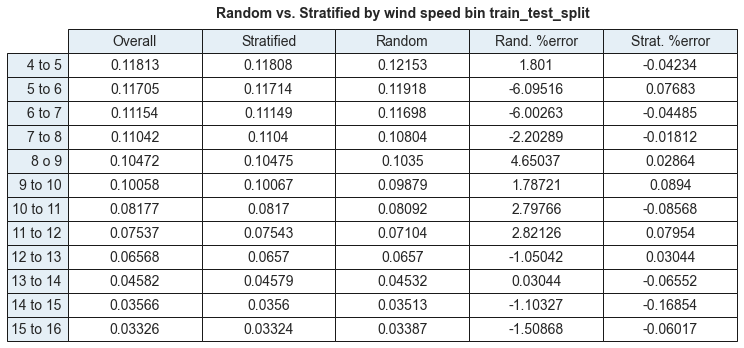

In [190]:
train_set2, test_set2 =test_split (data_iec2)

### Get x,y

In [191]:
#save the flags of column 'data'


flags=pd.DataFrame(test_set2['data'].copy())
flags=flags.reset_index(drop=True)
flags

,data
0,22
1,11
2,11
3,11
4,22
...,...
6372,11
6373,11
6374,17
6375,11


In [192]:
train_set2=train_set2.drop(columns=['data'])
test_set2=test_set2.drop(columns=['data'])

In [193]:
#data x,y


X_train2,y_train2=get_xy(train_set2)
X_test2,y_test2=get_xy(test_set2)

### Feature scaling

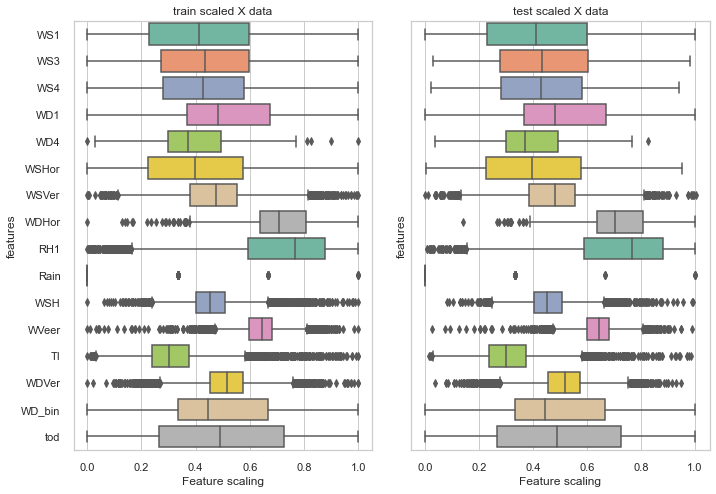

In [194]:
#feature scaling

X_train2, X_test2=data_scaling(X_train2, X_test2)

### Unappend

In [196]:
y_test2=pd.DataFrame(y_test2)
y_test2=y_test2.reset_index(drop=True)

In [197]:
y_test2

,Target
0,4.980434
1,9.503408
2,9.809653
3,6.731952
4,11.262453
...,...
6372,10.031869
6373,10.014604
6374,5.991016
6375,12.459098


In [198]:
X_test2['data']=flags.copy()
y_test2['data']=flags.copy()

In [204]:
X_test2

,WS1,WS3,WS4,WD1,WD4,WSHor,WSVer,WDHor,RH1,Rain,WSH,WVeer,TI,WDVer,WD_bin,tod,data
0,0.025342,0.092424,0.084434,0.096592,0.186337,0.034117,0.323589,0.486204,0.785774,0.0,0.599698,0.608875,0.495843,0.401289,0.000000,0.286713,22
1,0.533130,0.564791,0.583177,0.388258,0.299506,0.512985,0.476424,0.653094,0.958144,0.0,0.349101,0.668628,0.244154,0.506710,0.333333,0.461538,11
2,0.594923,0.617295,0.587578,0.879089,0.588762,0.575770,0.610131,0.922902,0.533058,0.0,0.435736,0.637027,0.347845,0.580392,0.888889,0.132867,11
3,0.270420,0.298930,0.310127,0.367391,0.297802,0.266229,0.480111,0.640307,0.871859,0.0,0.453396,0.655803,0.174576,0.551594,0.333333,0.062937,11
4,0.417796,0.412144,0.386870,0.640623,0.394615,0.391839,0.352256,0.788884,0.811550,0.0,0.549263,0.724089,0.322431,0.428434,0.666667,0.937063,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6372,0.550554,0.513000,0.444159,0.900726,0.686371,0.527244,0.481069,0.935047,0.617638,0.0,0.623475,0.522137,0.214316,0.508036,0.888889,0.944056,11
6373,0.427712,0.451191,0.468373,0.463077,0.327515,0.414760,0.535520,0.690984,0.952846,0.0,0.392050,0.685322,0.314112,0.563393,0.444444,0.846154,11
6374,0.229857,0.327434,0.314428,0.172401,0.154268,0.232180,0.457508,0.520208,NaN,0.0,0.370945,0.706640,0.258588,0.538147,0.111111,0.636364,17
6375,0.703335,0.695336,0.634500,0.858755,0.560878,0.676290,0.808346,0.916282,0.455876,0.0,0.495436,0.659602,0.402819,0.669408,0.888889,0.321678,11


In [200]:
X_test11=unappend_data (X_test2, 11)
X_test17=unappend_data (X_test2, 17)
X_test22=unappend_data (X_test2, 22)

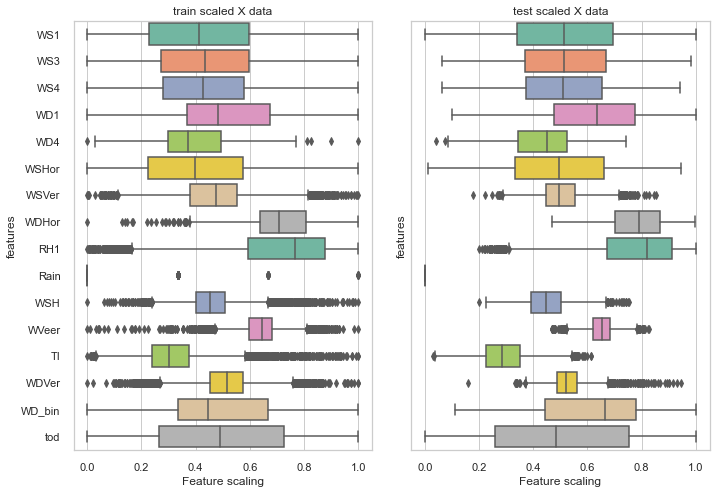

In [201]:
X_train2, X_test11=data_scaling(X_train2, X_test11)

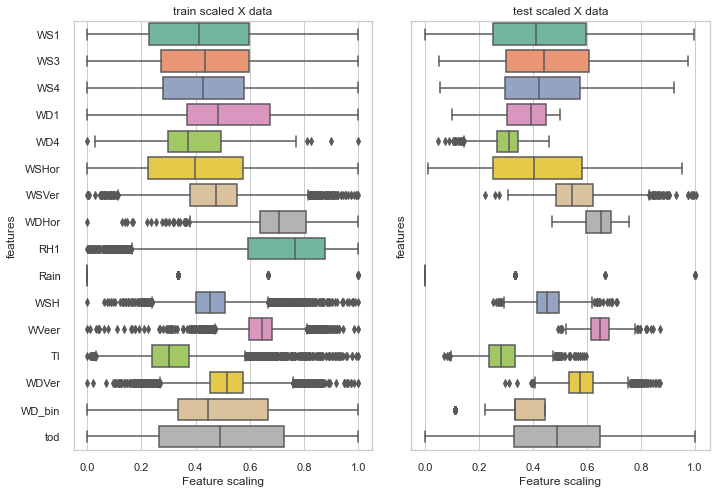

In [202]:
X_train2, X_test17=data_scaling(X_train2, X_test17)

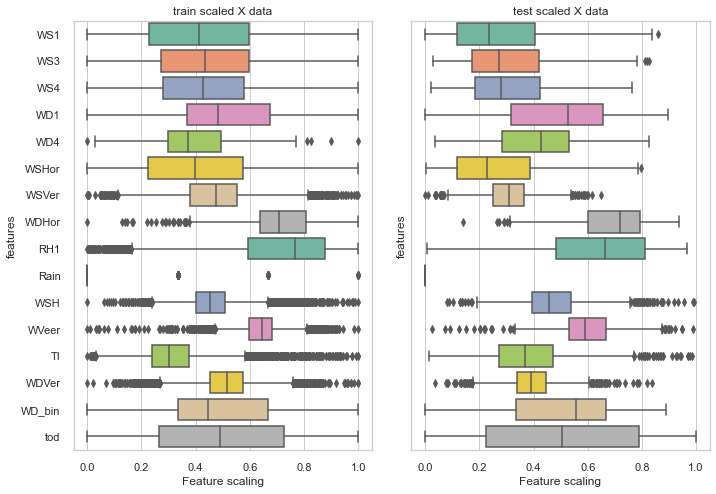

In [203]:
X_train2, X_test22=data_scaling(X_train2, X_test22)

In [206]:
y_test11=unappend_data (y_test2, 11)
y_test17=unappend_data (y_test2, 17)
y_test22=unappend_data (y_test2, 22)

In [207]:
y_test11

,Target
1,9.503408
2,9.809653
3,6.731952
5,12.074973
7,11.616336
...,...
6368,7.655211
6369,16.512230
6372,10.031869
6373,10.014604


### Data saving

In [208]:
save(X_train2,'\General','\X_train2.csv')
save(X_test11,'\General','\X_test11.csv')
save(X_test17,'\General','\X_test17.csv')
save(X_test22,'\General','\X_test22.csv')
save(y_train2,'\General','\y_train2.csv')
save(y_test11,'\General','\y_test11.csv')
save(y_test17,'\General','\y_test17.csv')
save(y_test22,'\General','\y_test22.csv')

file \X_train2.csv saved in \General folder
file \X_test11.csv saved in \General folder
file \X_test17.csv saved in \General folder
file \X_test22.csv saved in \General folder
file \y_train2.csv saved in \General folder
file \y_test11.csv saved in \General folder
file \y_test17.csv saved in \General folder
file \y_test22.csv saved in \General folder


## Dataset3

### WTG18

In [46]:
#upload the dataset with file_folder, file_name
data_ref18= uploading_csv('\Dataset3-New_Site','\data_iec18.csv')
data_ref18.keys()

Index(['time', 'HB_TM', 'Target', 'HB_ref', 'WS1', 'WS3', 'WS4', 'WSHor',
       'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1', 'T2', 'RH2', 'PR1', 'AD1',
       'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4', 'TI', 'WSH', 'WD_bin',
       'ratio', 'tod', 'Daily_Cycle', 'WVeer', 'PT1', 'PT2', 'PTG', 'N2',
       'incr_WS', 'Ri', 'Ri2', 'z_score'],
      dtype='object')

In [47]:
data18=data_ref18.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'PT1', 'PT2', 'PTG', 'N2', 'incr_WS', 'Ri', 'Ri2', 'ratio'])
data18.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [48]:
data_iec18=WDbins_uncomplete(data18)

Bins to drop:  []
Data removed for IEC computation:  0.0 %


In [49]:
data_iec18.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [50]:
data_iec18['data']=18

In [51]:
data_iec18

,Target,WS1,WS3,WS4,WSHor,WDHor,WSVer,WDVer,T1,RH1,...,Rain,WD1,WD3,WD4,TI,WSH,WD_bin,tod,WVeer,data
0,8.990304,8.409345,7.062099,5.454251,8.462000,175.2499,0.295833,1.879987,16.00720,82.44260,...,19.8000,178.3133,182.6316,186.264700,0.030196,0.347703,19,0.000000,-7.951400,18
1,8.867375,8.409575,7.137645,5.479765,8.496166,173.2735,0.266167,1.654993,15.97010,82.55798,...,19.8000,176.3502,181.4166,185.150100,0.019796,0.343977,19,0.166667,-8.799900,18
2,8.583167,8.139472,6.786590,4.999466,8.246666,168.3467,0.310667,1.999975,15.94968,82.43682,...,19.8000,171.4434,176.4965,181.157600,0.028395,0.391429,18,0.333333,-9.714200,18
3,8.112239,7.722917,6.274491,4.620833,7.830666,164.9150,0.278167,1.898322,15.88632,82.59558,...,19.8000,167.9384,173.0031,179.033400,0.034421,0.412489,18,0.500000,-11.095000,18
4,7.665986,7.399784,5.916017,4.253123,7.507500,163.6166,0.256500,1.789987,15.85618,82.67592,...,19.8000,166.5982,171.3282,178.064700,0.021402,0.444758,18,0.666667,-11.466500,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7429,9.048979,8.927596,8.422670,7.890725,8.984833,335.2919,-0.217833,-1.301600,20.95434,28.39884,...,255.3972,339.5502,7.0524,21.208870,0.054484,0.099151,35,12.166667,-41.658670,18
7430,8.758505,8.213539,7.637049,6.970308,8.215000,330.0140,-0.286333,-1.888000,20.27594,32.04780,...,255.3972,334.6075,356.1457,17.297610,0.056611,0.131809,34,12.333333,-42.690110,18
7431,8.455122,7.314699,6.797904,6.129249,7.328833,327.2632,-0.270333,-1.976600,19.75996,35.72224,...,255.3972,331.9382,347.5241,12.841581,0.031001,0.142000,34,12.500000,-40.903381,18
7432,7.628398,6.817953,5.944155,4.895203,6.789333,323.6449,-0.267833,-2.186400,19.83738,38.25000,...,255.3972,328.2630,346.8061,7.353411,0.057205,0.266072,34,12.666667,-39.090411,18


### WTG20

In [52]:
#upload the dataset with file_folder, file_name
data_ref20= uploading_csv('\Dataset3-New_Site','\data_iec20.csv')
data_ref20.keys()

Index(['time', 'HB_TM', 'Target', 'HB_ref', 'WS1', 'WS3', 'WS4', 'WSHor',
       'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1', 'T2', 'RH2', 'PR1', 'AD1',
       'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4', 'TI', 'WSH', 'WD_bin',
       'ratio', 'tod', 'Daily_Cycle', 'WVeer', 'PT1', 'PT2', 'PTG', 'N2',
       'incr_WS', 'Ri', 'Ri2', 'z_score'],
      dtype='object')

In [53]:
data20=data_ref20.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'PT1', 'PT2', 'PTG', 'N2', 'incr_WS', 'Ri', 'Ri2', 'ratio'])
data20.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [54]:
data_iec20=WDbins_uncomplete(data20)

Bins to drop:  []
Data removed for IEC computation:  0.0 %


In [55]:
data_iec20.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [56]:
data_iec20['data']=20

In [57]:
data_iec20

,Target,WS1,WS3,WS4,WSHor,WDHor,WSVer,WDVer,T1,RH1,...,Rain,WD1,WD3,WD4,TI,WSH,WD_bin,tod,WVeer,data
0,8.810404,8.409345,7.062099,5.454251,8.462000,175.24990,0.295833,1.879987,16.00720,82.44260,...,19.8000,178.31330,182.63160,186.26470,0.030196,0.347703,18,0.000000,-7.95140,20
1,8.715114,8.409575,7.137645,5.479765,8.496166,173.27350,0.266167,1.654993,15.97010,82.55798,...,19.8000,176.35020,181.41660,185.15010,0.019796,0.343977,18,0.166667,-8.79990,20
2,8.395617,8.139472,6.786590,4.999466,8.246666,168.34670,0.310667,1.999975,15.94968,82.43682,...,19.8000,171.44340,176.49650,181.15760,0.028395,0.391429,18,0.333333,-9.71420,20
3,8.026525,7.722917,6.274491,4.620833,7.830666,164.91500,0.278167,1.898322,15.88632,82.59558,...,19.8000,167.93840,173.00310,179.03340,0.034421,0.412489,17,0.500000,-11.09500,20
4,7.488778,7.399784,5.916017,4.253123,7.507500,163.61660,0.256500,1.789987,15.85618,82.67592,...,19.8000,166.59820,171.32820,178.06470,0.021402,0.444758,17,0.666667,-11.46650,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5280,10.368006,9.358994,7.481286,5.854040,9.258334,79.38966,0.320833,2.152709,10.37362,71.64928,...,188.3983,83.01376,86.93081,90.85806,0.115907,0.376822,9,22.833333,-7.84430,20
5281,9.999909,8.353872,6.685956,5.643378,8.259333,82.79046,0.406167,3.276973,10.26614,72.19632,...,188.3983,86.35690,91.11125,99.23883,0.172246,0.315012,9,23.000000,-12.88193,20
5282,9.341196,8.239019,6.379863,5.037964,8.175667,83.53655,0.286167,2.397547,10.25222,72.18606,...,188.3983,87.05166,92.15962,95.71485,0.170446,0.395031,9,23.166667,-8.66319,20
5283,9.468507,8.853754,6.785745,5.602433,8.712833,79.85524,0.303833,2.408860,10.25792,72.06114,...,188.3983,83.25931,87.25276,93.21884,0.194056,0.367534,9,23.333333,-9.95953,20


### WTG43

In [58]:
#upload the dataset with file_folder, file_name
data_ref43= uploading_csv('\Dataset3-New_Site','\data_iec43.csv')
data_ref43.keys()

Index(['time', 'HB_TM', 'Target', 'HB_ref', 'WS1', 'WS3', 'WS4', 'WSHor',
       'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1', 'T2', 'RH2', 'PR1', 'AD1',
       'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4', 'TI', 'WSH', 'WD_bin',
       'ratio', 'tod', 'Daily_Cycle', 'WVeer', 'PT1', 'PT2', 'PTG', 'N2',
       'incr_WS', 'Ri', 'Ri2', 'z_score'],
      dtype='object')

In [59]:
data43=data_ref43.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'PT1', 'PT2', 'PTG', 'N2', 'incr_WS', 'Ri', 'Ri2', 'ratio'])
data43.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [60]:
data_iec43=WDbins_uncomplete(data43)

Bins to drop:  []
Data removed for IEC computation:  0.0 %


In [61]:
data_iec43.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [62]:
data_iec43['data']=43

In [63]:
data_iec43

,Target,WS1,WS3,WS4,WSHor,WDHor,WSVer,WDVer,T1,RH1,...,Rain,WD1,WD3,WD4,TI,WSH,WD_bin,tod,WVeer,data
0,9.504436,9.351389,7.900164,6.155996,9.429500,90.64462,0.048167,0.370974,22.28386,25.17884,...,5.0000,96.5940,96.54774,96.1547,0.063828,0.335777,10,0.166667,0.4393,43
1,9.838129,9.166853,7.569650,5.999692,9.228166,90.25480,0.092833,0.650790,22.25868,25.30102,...,5.0000,96.0098,95.70884,95.1148,0.080239,0.340425,10,0.333333,0.8950,43
2,9.996484,9.264428,7.747125,6.056982,9.361500,91.68941,-0.045833,-0.092400,22.23876,25.39152,...,5.0000,97.7885,96.76599,99.4074,0.105115,0.341296,10,0.500000,-1.6189,43
3,10.061125,9.368417,8.108723,6.287892,9.421500,90.66321,0.022500,0.290529,22.17154,25.73740,...,5.0000,96.5896,96.75627,96.5364,0.093883,0.320213,10,0.666667,0.0532,43
4,9.622169,9.082104,7.563006,5.969483,9.160834,91.86718,0.155500,1.033866,22.08058,26.25026,...,5.0000,97.7661,97.32643,96.8202,0.096101,0.337020,10,0.833333,0.9459,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388,5.558945,4.815819,3.402856,1.906330,4.729166,84.80499,0.000667,-0.043300,12.10962,63.17768,...,259.7975,90.5015,92.72671,79.7855,0.022783,0.744260,10,11.000000,10.7160,43
6389,5.176754,4.881634,3.364367,2.164701,4.835833,84.26829,0.082333,0.854993,12.27580,62.27758,...,259.7975,89.9383,83.19666,70.7666,0.031424,0.653084,9,11.166667,19.1717,43
6390,5.107445,4.820936,3.182385,2.106268,4.819333,83.62173,0.055500,0.568326,12.27420,62.59202,...,259.7975,89.2633,79.74815,76.4672,0.034920,0.665012,9,11.333333,12.7961,43
6391,4.985424,4.453691,2.713265,1.822570,4.476167,81.97341,0.058167,0.649993,12.36100,62.69808,...,259.7975,87.5166,74.84622,74.2647,0.020326,0.717563,9,11.500000,13.2519,43


### WTG46

In [64]:
#upload the dataset with file_folder, file_name
data_ref46= uploading_csv('\Dataset3-New_Site','\data_iec46.csv')
data_ref46.keys()

Index(['time', 'HB_TM', 'Target', 'HB_ref', 'WS1', 'WS3', 'WS4', 'WSHor',
       'WDHor', 'WSVer', 'WDVer', 'T1', 'RH1', 'T2', 'RH2', 'PR1', 'AD1',
       'PR2', 'AD2', 'Rain', 'WD1', 'WD3', 'WD4', 'TI', 'WSH', 'WD_bin',
       'ratio', 'tod', 'Daily_Cycle', 'WVeer', 'PT1', 'PT2', 'PTG', 'N2',
       'incr_WS', 'Ri', 'Ri2', 'z_score'],
      dtype='object')

In [65]:
data46=data_ref46.drop(columns=['time', 'HB_ref', 'Daily_Cycle', 'HB_TM', 'z_score', 'PT1', 'PT2', 'PTG', 'N2', 'incr_WS', 'Ri', 'Ri2', 'ratio'])
data46.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [66]:
data_iec46=WDbins_uncomplete(data46)

Bins to drop:  []
Data removed for IEC computation:  0.0 %


In [67]:
data_iec46.keys()

Index(['Target', 'WS1', 'WS3', 'WS4', 'WSHor', 'WDHor', 'WSVer', 'WDVer', 'T1',
       'RH1', 'T2', 'RH2', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WD1', 'WD3',
       'WD4', 'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [68]:
data_iec46['data']=46

In [69]:
data_iec46

,Target,WS1,WS3,WS4,WSHor,WDHor,WSVer,WDVer,T1,RH1,...,Rain,WD1,WD3,WD4,TI,WSH,WD_bin,tod,WVeer,data
0,8.684505,8.484206,7.308247,6.043329,8.560833,92.36068,0.101000,0.755013,22.25270,25.21998,...,5.0000,98.3334,99.15975,98.03700,0.100586,0.272455,11,0.000000,0.29640,46
1,9.296429,9.351389,7.900164,6.155996,9.429500,90.64462,0.048167,0.370974,22.28386,25.17884,...,5.0000,96.5940,96.54774,96.15470,0.063828,0.335777,11,0.166667,0.43930,46
2,9.512659,9.166853,7.569650,5.999692,9.228166,90.25480,0.092833,0.650790,22.25868,25.30102,...,5.0000,96.0098,95.70884,95.11480,0.080239,0.340425,11,0.333333,0.89500,46
3,9.827873,9.264428,7.747125,6.056982,9.361500,91.68941,-0.045833,-0.092400,22.23876,25.39152,...,5.0000,97.7885,96.76599,99.40740,0.105115,0.341296,11,0.500000,-1.61890,46
4,9.927618,9.368417,8.108723,6.287892,9.421500,90.66321,0.022500,0.290529,22.17154,25.73740,...,5.0000,96.5896,96.75627,96.53640,0.093883,0.320213,11,0.666667,0.05320,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6512,5.114455,4.881634,3.364367,2.164701,4.835833,84.26829,0.082333,0.854993,12.27580,62.27758,...,259.7975,89.9383,83.19666,70.76660,0.031424,0.653084,10,11.166667,19.17170,46
6513,4.970914,4.820936,3.182385,2.106268,4.819333,83.62173,0.055500,0.568326,12.27420,62.59202,...,259.7975,89.2633,79.74815,76.46720,0.034920,0.665012,10,11.333333,12.79610,46
6514,4.591347,4.453691,2.713265,1.822570,4.476167,81.97341,0.058167,0.649993,12.36100,62.69808,...,259.7975,87.5166,74.84622,74.26470,0.020326,0.717563,10,11.500000,13.25190,46
6515,4.314888,4.488277,2.719298,1.846753,4.471167,79.22502,0.142167,1.691630,12.15546,63.59786,...,259.7975,84.8350,76.03554,81.84940,0.024519,0.713190,9,11.666667,2.98560,46


### Append

In [70]:
data_iec3=data_iec18.append([data_iec20, data_iec43, data_iec46])
data_iec3=data_iec3.reset_index(drop=True)

### Data split

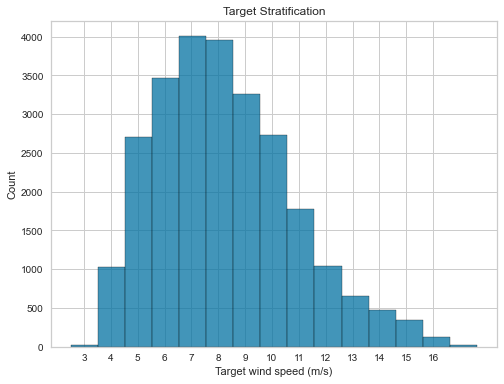

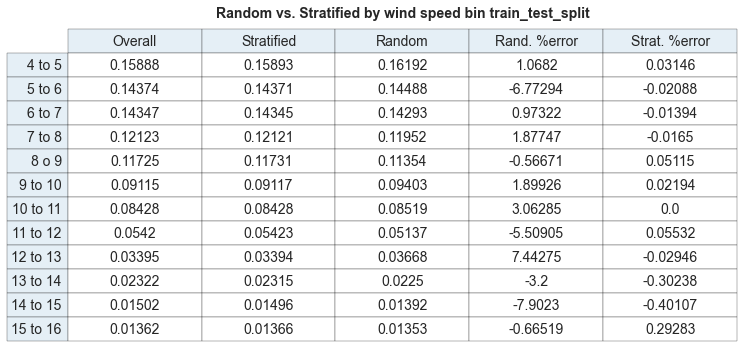

In [71]:
train_set3, test_set3 =test_split (data_iec3)

### Get x,y

In [72]:
#save the flags of column 'data'


flags=pd.DataFrame(test_set3['data'].copy())
flags=flags.reset_index(drop=True)
flags

,data
0,46
1,43
2,18
3,46
4,20
...,...
7684,20
7685,18
7686,18
7687,20


In [73]:
flags['data'].value_counts()

18    2169
46    1959
43    1913
20    1648
Name: data, dtype: int64

In [261]:
train_set3=train_set3.drop(columns=['data'])
test_set3=test_set3.drop(columns=['data'])

In [262]:
#data x,y


X_train3,y_train3=get_xy(train_set3)
X_test3,y_test3=get_xy(test_set3)

### Feature scaling

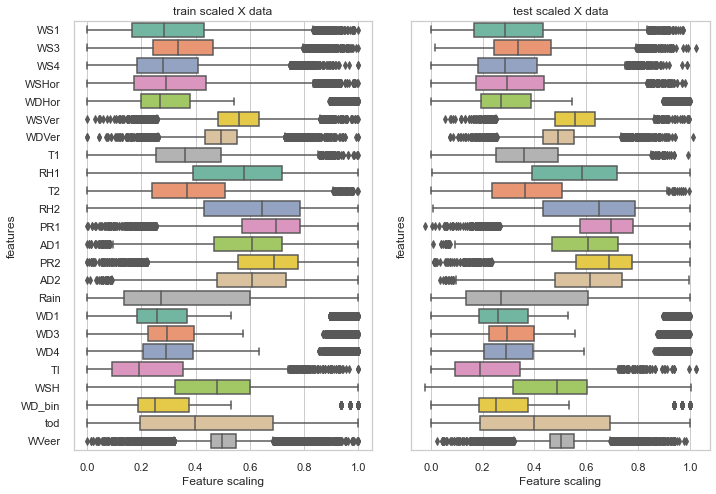

In [263]:
#feature scaling

X_train3, X_test3=data_scaling(X_train3, X_test3)

### Unappend

In [264]:
y_test3=pd.DataFrame(y_test3)
y_test3=y_test3.reset_index(drop=True)

In [265]:
X_test3['data']=flags.copy()
y_test3['data']=flags.copy()

In [266]:
X_test18=unappend_data (X_test3, 18)
X_test20=unappend_data (X_test3, 20)
X_test43=unappend_data (X_test3, 43)
X_test46=unappend_data (X_test3, 46)

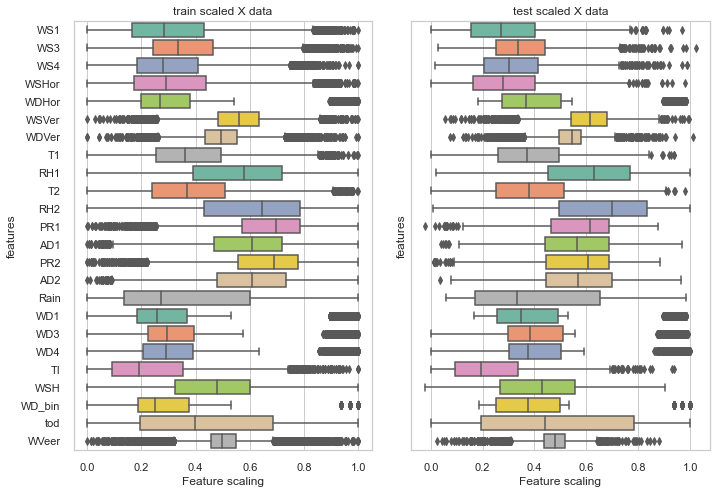

In [267]:
X_train3, X_test18=data_scaling(X_train3, X_test18)

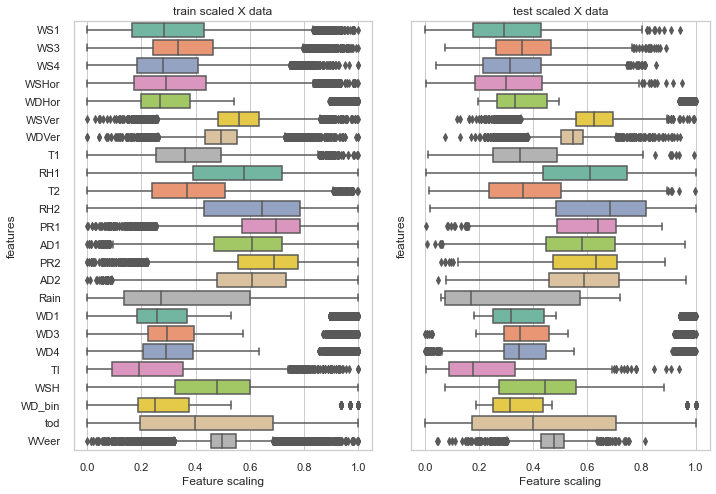

In [268]:
X_train3, X_test20=data_scaling(X_train3, X_test20)

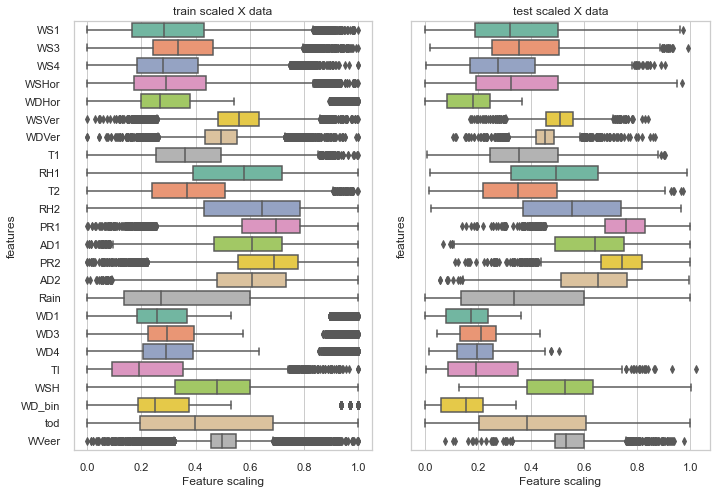

In [269]:
X_train3, X_test43=data_scaling(X_train3, X_test43)

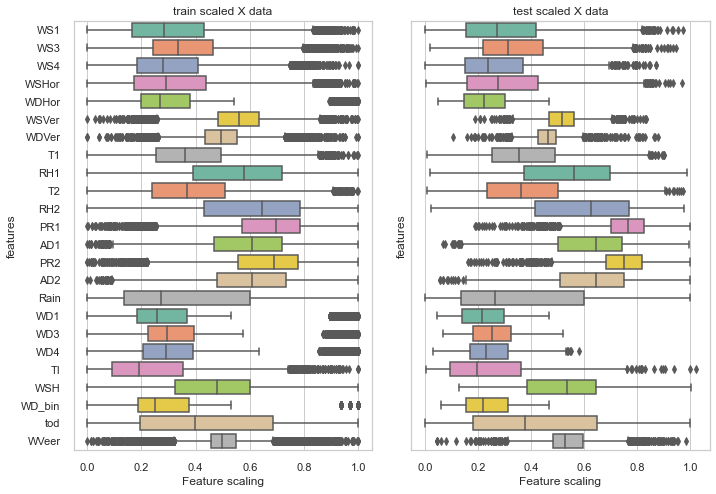

In [270]:
X_train3, X_test46=data_scaling(X_train3, X_test46)

In [271]:
y_test18=unappend_data (y_test3, 18)
y_test20=unappend_data (y_test3, 20)
y_test43=unappend_data (y_test3, 43)
y_test46=unappend_data (y_test3, 46)

### Data saving

In [272]:
save(X_train3,'\General','\X_train3.csv')
save(X_test18,'\General','\X_test18.csv')
save(X_test20,'\General','\X_test20.csv')
save(X_test43,'\General','\X_test43.csv')
save(X_test46,'\General','\X_test46.csv')
save(y_train3,'\General','\y_train3.csv')
save(y_test18,'\General','\y_test18.csv')
save(y_test20,'\General','\y_test20.csv')
save(y_test43,'\General','\y_test43.csv')
save(y_test46,'\General','\y_test46.csv')

file \X_train3.csv saved in \General folder
file \X_test18.csv saved in \General folder
file \X_test20.csv saved in \General folder
file \X_test43.csv saved in \General folder
file \X_test46.csv saved in \General folder
file \y_train3.csv saved in \General folder
file \y_test18.csv saved in \General folder
file \y_test20.csv saved in \General folder
file \y_test43.csv saved in \General folder
file \y_test46.csv saved in \General folder


# Copy-paste cells

In [ ]:
import nbformat as nbf
from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

# your notebook name/keyword
nb_name = 'Dataset1- Preparation- V2-Copy3'
notebooks = list(filter(lambda x: nb_name in x, glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

    nbf.write(ntbk, ipath)